In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pydot

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
performance = pd.DataFrame()
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-A', 'TSLA', 'LLY', 'JPM']
for ticker in tickers:
    folder_path = f'C:\\Users\\pc\\OneDrive\\桌面\\CSE 6740\\Final Project\\h5\\{ticker}'
    # Hybrid Method
    df = yf.Ticker(ticker).history(start = '2013-01-01', end = '2023-01-01')
    df = df.drop(columns= ['Dividends', 'Stock Splits'])
    df.ffill(inplace = True)
    df.reset_index(inplace = True)

    df['open-close'] = df['Open'] - df['Close']
    df['high-low'] = df['High'] - df['Low']

    intervals = [5, 30, 60, 252]
    for interval in intervals:
        df[f'ema{interval}'] = df['Close'] / df['Close'].ewm(span = interval).mean()
        df[f'ave{interval}'] = df['Close'] / df['Close'].rolling(interval, min_periods = 1).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))

    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2

    df['norm_vol'] = df['Volume'] / df['Volume'].ewm(5).mean()
    df['vol_change'] = df['Volume'].pct_change()

    df.replace([np.inf, -np.inf], 0, inplace = True)
    df = df.dropna(how = 'any', axis= 0)
    df = df.drop(columns= ['Open', 'High', 'Low', 'Volume'])

    features = list(df.columns[1:])

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_columns = scaler.fit_transform(df[features])
    df_scaled = pd.DataFrame(scaled_columns, columns=features)
    train_size = int(len(df_scaled) * 0.9)
    train, test = df_scaled[:train_size], df_scaled[train_size - 60:]

    def create_dataset(X, time_steps=1):
        Xs = []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
        return np.array(Xs)

    time_steps = 60
    X_train = create_dataset(train, time_steps)
    X_test = create_dataset(test, time_steps)

    y_train = train[features].values[time_steps:]
    y_test = test[features].values[time_steps:]

    def create_lstm_model(input_shape):
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= input_shape))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    lstm_models = {}
    train_predictions = {}
    test_predictions = {}

    for feature in features:
        model_path = os.path.join(folder_path, f'{ticker}_lstm_xgboost_model_{feature}.h5')
        lstm_model = load_model(model_path)
        print(lstm_model.input_shape)
        print(X_train.shape)

        # print(f"Training model of {ticker} for {feature}")
        # lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
        feature_index = train.columns.get_loc(feature)
        # lstm_model.fit(X_train, y_train[:, feature_index], epochs=100, batch_size=64, verbose=1, validation_split=0.1)

        train_pred = lstm_model.predict(X_train)
        test_pred = lstm_model.predict(X_test)

        train_predictions[feature] = train_pred
        test_predictions[feature] = test_pred
        lstm_models[feature] = lstm_model

        # folder_path = f'C:\\Users\\pc\\OneDrive\\桌面\\CSE 6740\\Final Project\\h5\\{ticker}'
        # if not os.path.exists(folder_path):
        #     os.makedirs(folder_path)
        # lstm_model.save(f'{folder_path}\\{ticker}_lstm_xgboost_model_{feature}.h5')

    train_preds = np.column_stack(list(train_predictions.values()))
    test_preds = np.column_stack(list(test_predictions.values()))

    target_feature = 'Close'
    y_train_target = y_train[:, features.index(target_feature)]
    y_test_target = y_test[:, features.index(target_feature)]

    train_preds_df = pd.DataFrame(train_preds, columns=features)

    parameters = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.001, 0.005, 0.01, 0.05],
        'max_depth': [10, 12, 15],
        'gamma': [0.001, 0.005, 0.01, 0.02],
        'random_state': [42]
    }

    # xgb_model_1 = xgb.XGBRegressor(objective='reg:squarederror')
    # clf = GridSearchCV(xgb_model_1, parameters)
    # clf.fit(train_preds_df, y_train_target)

    # model_1 = clf.best_estimator_
    model_1 = xgb.XGBRegressor()
    model_1.load_model(f'{folder_path}\\{ticker}_lstm_xgboost_model.json')
    # model_1.save_model(f'{folder_path}\\{ticker}_lstm_xgboost_model.json')

    y_pred = model_1.predict(test_preds)
    close_index = 0
    y_pred_reshaped = np.zeros((y_pred.shape[0], len(scaler.scale_)))
    y_pred_reshaped[:, close_index] = y_pred.flatten()
    y_pred = scaler.inverse_transform(y_pred_reshaped)[:, close_index]

    y_test_target_reshaped = np.zeros((y_test_target.shape[0], len(scaler.scale_)))
    y_test_target_reshaped[:, close_index] = y_test_target.flatten()
    y_test_target = scaler.inverse_transform(y_test_target_reshaped)[:, close_index]

    performance = performance.append({
            'Ticker': ticker,
            'Model': 'Hybrid',
            'RMSE': mean_squared_error(y_test_target, y_pred),
            'MAE': mean_absolute_error(y_test_target, y_pred),
            'R2': r2_score(y_test_target, y_pred)
        }, ignore_index=True)

    # LSTM
    df = yf.Ticker(ticker).history(start = '2013-01-01', end = '2023-01-01')
    df = df.drop(columns= ['Dividends', 'Stock Splits'])
    df.ffill(inplace = True)
    df.reset_index(inplace = True)

    lstm_data = df.filter(['Close']).values
    scaler_2 = MinMaxScaler(feature_range=(0, 1))
    scaler_data = scaler_2.fit_transform(lstm_data)

    # Create Training lstm_data
    train_length = int(np.ceil(len(lstm_data) * 0.9))
    train_data = scaler_data[0:int(train_length), :]
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print(x_train)
            print(y_train)
            print()

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # ## Model construction
    # lstm_model = Sequential()
    # lstm_model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    # lstm_model.add(Dropout(0.2))
    # lstm_model.add(LSTM(64, return_sequences=False))
    # lstm_model.add(Dropout(0.2))
    # lstm_model.add(Dense(25))
    # lstm_model.add(Dense(1))

    # # Compile the model
    # lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    # lstm_model.fit(x_train, y_train, batch_size=1, epochs=1)
    # lstm_model.save(f'{folder_path}\\{ticker}_lstm_model.h5')
    lstm_model = load_model(f'{folder_path}\\{ticker}_lstm_model.h5')

    # Create a new array containing scaled values from index 1543 to 2002
    test_data = scaler_data[train_length - 60: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = lstm_data[train_length:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values
    predictions = lstm_model.predict(x_test)
    predictions = scaler_2.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    performance = performance.append({
            'Ticker': ticker,
            'Model': 'LSTM',
            'RMSE': mean_squared_error(predictions, y_test),
            'MAE': mean_absolute_error(predictions, y_test),
            'R2': r2_score(y_test, predictions)
        }, ignore_index=True)

    # XGBoost
    xg_data = yf.Ticker(ticker).history(start = '2013-01-01', end = '2023-01-01')
    xg_data.reset_index(inplace=True)

    xg_data['open-close'] = xg_data['Open'] - xg_data['Close']
    xg_data['high-low'] = xg_data['High'] - xg_data['Low']

    intervals = [5, 30, 60, 252]
    for interval in intervals:
        xg_data[f'ema{interval}'] = xg_data['Close'] / xg_data['Close'].ewm(span = interval).mean()
        xg_data[f'ave{interval}'] = xg_data['Close'] / xg_data['Close'].rolling(interval, min_periods = 1).mean()

    delta = xg_data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down
    xg_data['RSI'] = 100 - (100 / (1 + rs))

    exp1 = xg_data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = xg_data['Close'].ewm(span=26, adjust=False).mean()
    xg_data['MACD'] = exp1 - exp2

    xg_data['norm_vol'] = xg_data['Volume'] / xg_data['Volume'].ewm(5).mean()
    xg_data['vol_change'] = xg_data['Volume'].pct_change()
    xg_data['Target'] = xg_data['Close'].shift(-1)

    xg_data.replace([np.inf, -np.inf], 0, inplace = True)
    xg_data = xg_data.dropna(how = 'any', axis= 0)
    xg_data = xg_data.drop(columns= ['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])

    test_size  = 0.1
    valid_size = 0.1

    test_split_idx  = int(xg_data.shape[0] * (1-test_size))
    valid_split_idx = int(xg_data.shape[0] * (1-(valid_size+test_size)))

    train_df  = xg_data.loc[:valid_split_idx].copy()
    valid_df  = xg_data.loc[valid_split_idx+1:test_split_idx].copy()
    test_df   = xg_data.loc[test_split_idx+1:].copy()

    drop_cols = ['Date']
    train_df = train_df.drop(columns= drop_cols)
    valid_df = valid_df.drop(columns= drop_cols)
    test_df  = test_df.drop(columns= drop_cols)

    y_train = train_df['Target'].copy()
    X_train = train_df.drop(columns = ['Target'])

    y_valid = valid_df['Target'].copy()
    X_valid = valid_df.drop(columns= ['Target'])

    y_test  = test_df['Target'].copy()
    X_test  = test_df.drop(columns= ['Target'])

    parameters = {
        'n_estimators': [300],
        'learning_rate': [0.05],
        'max_depth': [10],
        'gamma': [0.02],
        'random_state': [42]
    }

    # eval_set = [(X_train, y_train), (X_valid, y_valid)]

    # xgb_model_2 = xgb.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=10)
    # clf = GridSearchCV(xgb_model_2, parameters)
    # fit_params = {'eval_set': eval_set, 'verbose': False}
    # clf.fit(X_train, y_train, **fit_params)

    # model_2 = clf.best_estimator_
    # model_2.save_model(f'{folder_path}\\{ticker}_xgboost_model.json')
    model_2 = xgb.XGBRegressor()
    model_2.load_model(f'{folder_path}\\{ticker}_xgboost_model.json')

    y_pred = model_2.predict(X_test)
    performance = performance.append({
            'Ticker': ticker,
            'Model': 'XGBoost',
            'RMSE': mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }, ignore_index=True)


(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 1

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 7ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 7ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 9ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 1s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 7ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15)
8/8 [==============================] - 0s 8ms/step
(None, 60, 15)
(2205, 60, 15

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:133: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



8/8 [==============================] - 0s 8ms/step


C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:207: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\pc\AppData\Local\Temp\ipykernel_4712\738742158.py:292: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [3]:
performance

,Ticker,Model,RMSE,MAE,R2
0,AAPL,Hybrid,3.482769e+01,4.945734,0.787382
1,AAPL,LSTM,3.962802e+01,5.059334,0.756179
2,AAPL,XGBoost,7.576860e+02,24.715659,-3.625562
3,MSFT,Hybrid,8.289843e+01,7.256787,0.867695
4,MSFT,LSTM,9.212323e+01,7.781390,0.849536
5,MSFT,XGBoost,3.301929e+03,51.794683,-4.269843
6,GOOGL,Hybrid,2.175870e+01,3.798811,0.916641
7,GOOGL,LSTM,1.808795e+01,3.478967,0.930019
8,GOOGL,XGBoost,1.077525e+03,28.567561,-3.128069
9,AMZN,Hybrid,4.219794e+01,5.025948,0.926408


In [4]:
performance['RMSE'] = pd.to_numeric(performance['RMSE'])
performance['MAE'] = pd.to_numeric(performance['MAE'])
performance

,Ticker,Model,RMSE,MAE,R2
0,AAPL,Hybrid,3.482769e+01,4.945734,0.787382
1,AAPL,LSTM,3.962802e+01,5.059334,0.756179
2,AAPL,XGBoost,7.576860e+02,24.715659,-3.625562
3,MSFT,Hybrid,8.289843e+01,7.256787,0.867695
4,MSFT,LSTM,9.212323e+01,7.781390,0.849536
5,MSFT,XGBoost,3.301929e+03,51.794683,-4.269843
6,GOOGL,Hybrid,2.175870e+01,3.798811,0.916641
7,GOOGL,LSTM,1.808795e+01,3.478967,0.930019
8,GOOGL,XGBoost,1.077525e+03,28.567561,-3.128069
9,AMZN,Hybrid,4.219794e+01,5.025948,0.926408


In [21]:
performance_try = performance_try[(performance_try['Ticker'] != 'BRK-A') & (performance_try['Ticker'] != 'LLY') ]

In [22]:
grouped_rmse = performance_try.groupby('Model')['RMSE'].agg(['mean', 'std'])
grouped_mae = performance_try.groupby('Model')['MAE'].agg(['mean', 'std'])
grouped_r2 = performance_try.groupby('Model')['R2'].agg(['mean', 'std'])

In [23]:
grouped_rmse

,mean,std
Model,,
Hybrid,119.903233,137.819645
LSTM,222.284008,286.160026
XGBoost,2023.841348,2293.782087


In [24]:
grouped_mae

,mean,std
Model,,
Hybrid,7.178483,3.939826
LSTM,10.852539,7.012963
XGBoost,30.234418,22.707034


In [25]:
grouped_r2

,mean,std
Model,,
Hybrid,0.890667,0.063389
LSTM,0.763305,0.222566
XGBoost,-1.375534,2.061751


In [26]:
performance_try

,Ticker,Model,RMSE,MAE,R2
0,AAPL,Hybrid,34.827689,4.945734,0.787382
1,AAPL,LSTM,39.628019,5.059334,0.756179
2,AAPL,XGBoost,757.685977,24.715659,-3.625562
3,MSFT,Hybrid,82.898431,7.256787,0.867695
4,MSFT,LSTM,92.123232,7.781390,0.849536
5,MSFT,XGBoost,3301.928713,51.794683,-4.269843
6,GOOGL,Hybrid,21.758698,3.798811,0.916641
7,GOOGL,LSTM,18.087950,3.478967,0.930019
8,GOOGL,XGBoost,1077.524533,28.567561,-3.128069
9,AMZN,Hybrid,42.197939,5.025948,0.926408


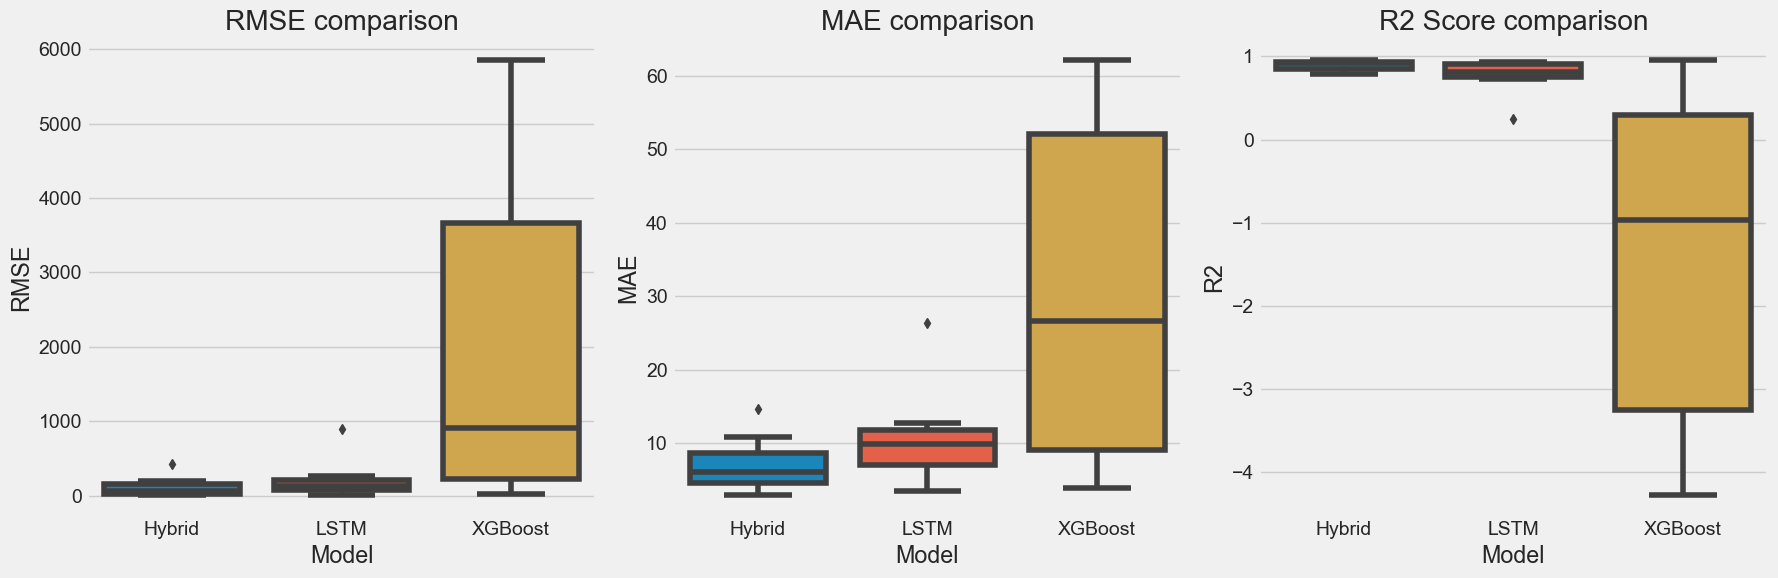

In [27]:
f, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a boxplot for RMSE
sns.boxplot(x='Model', y='RMSE', data=performance_try, ax=axes[0])
axes[0].set_title('RMSE comparison')

# Create a boxplot for MAE
sns.boxplot(x='Model', y='MAE', data=performance_try, ax=axes[1])
axes[1].set_title('MAE comparison')

# Create a boxplot for R2
sns.boxplot(x='Model', y='R2', data=performance_try, ax=axes[2])
axes[2].set_title('R2 Score comparison')

plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 假设df是你的DataFrame


for metric in ['RMSE', 'MAE', 'R2']:
    # ANOVA
    model = ols(f'{metric} ~ Model', data=performance_try).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA table for {metric}:\n", anova_table)

    # If ANOVA shows significance, perform Tukey's HSD test
    if anova_table['PR(>F)'][0] < 0.05:
        print(f"Performing Tukey's HSD test for {metric}...\n")
        tukey = pairwise_tukeyhsd(endog=performance_try[metric], groups=performance_try['Model'], alpha=0.05)
        print(tukey)

ANOVA table for RMSE:
                 sum_sq    df         F    PR(>F)
Model     1.834952e+07   2.0  5.132908  0.015313
Residual  3.753623e+07  21.0       NaN       NaN
Performing Tukey's HSD test for RMSE...

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1  group2  meandiff p-adj    lower      upper   reject
-----------------------------------------------------------
Hybrid    LSTM  102.3808 0.9872 -1582.5594  1787.321  False
Hybrid XGBoost 1903.9381  0.025   218.9979 3588.8783   True
  LSTM XGBoost 1801.5573 0.0347   116.6172 3486.4975   True
-----------------------------------------------------------
ANOVA table for MAE:
                sum_sq    df         F    PR(>F)
Model     2455.285451   2.0  6.346448  0.006985
Residual  4062.193071  21.0       NaN       NaN
Performing Tukey's HSD test for MAE...

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------

In [8]:
# Pivot the DataFrame for RMSE
rmse_pivot = performance.pivot(index='Ticker', columns='Model', values='RMSE')

# Pivot the DataFrame for MAE
mae_pivot = performance.pivot(index='Ticker', columns='Model', values='MAE')

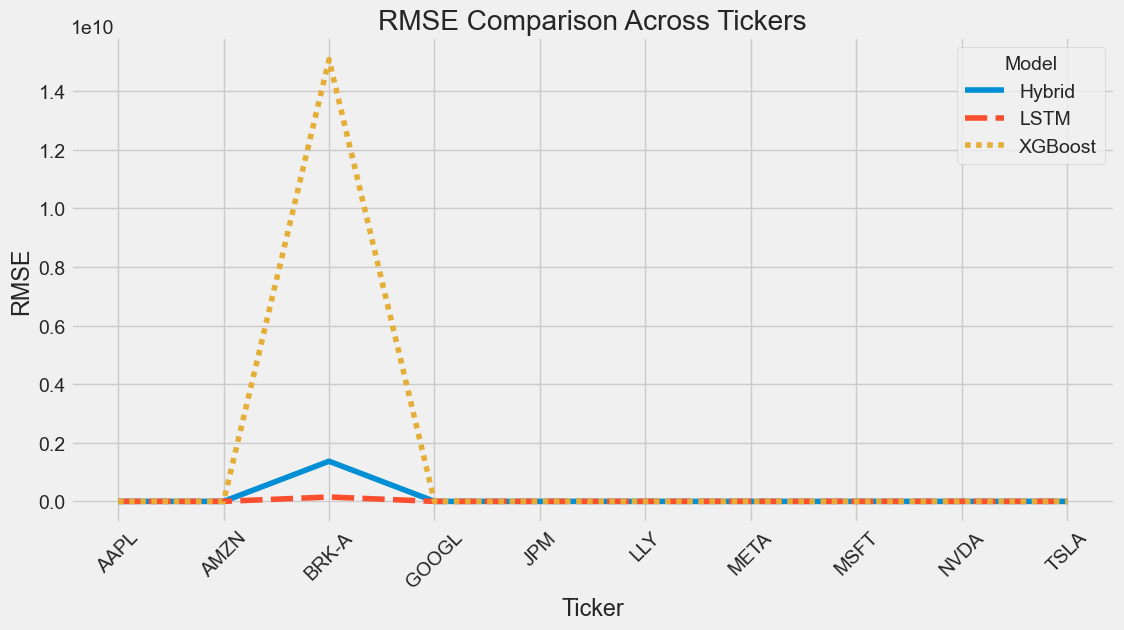

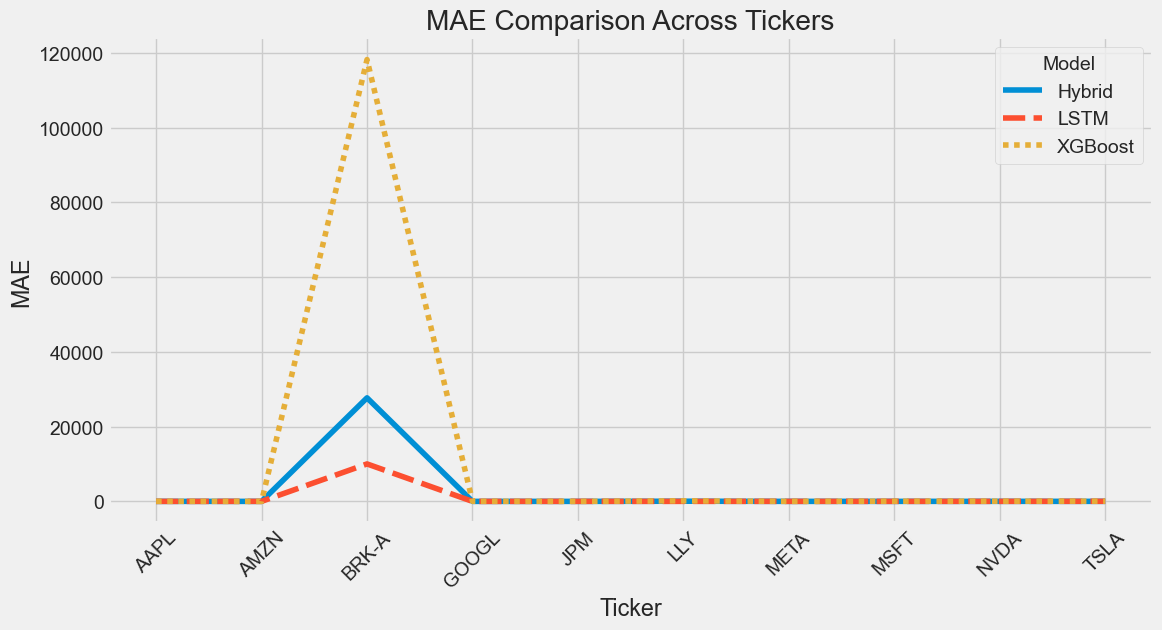

In [9]:
# Plotting RMSE
plt.figure(figsize=(12, 6))
sns.lineplot(data=rmse_pivot)
plt.title('RMSE Comparison Across Tickers')
plt.ylabel('RMSE')
plt.xlabel('Ticker')
plt.xticks(rotation=45)  # Rotate tick labels for better readability
plt.legend(title='Model')
plt.show()

# Plotting MAE
plt.figure(figsize=(12, 6))
sns.lineplot(data=mae_pivot)
plt.title('MAE Comparison Across Tickers')
plt.ylabel('MAE')
plt.xlabel('Ticker')
plt.xticks(rotation=45)  # Rotate tick labels for better readability
plt.legend(title='Model')
plt.show()